Use transfer learning on a pretrained ResNet model from pytorch (trained on ImageNet) for classification of CIFAR10

Import Libraries

In [53]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision
from torch import nn

# For plotting and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            f1_score, precision_score, recall_score, roc_auc_score

import pandas as pd
import numpy as np

Transform data for pytorch

In [14]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256,256)),
])

Load the CIFAR10 dataset

In [15]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
# Get class labels
classes = []
class_idx = []
for key, val in trainset.class_to_idx.items():
  classes.append(key)
  class_idx.append(val)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Get a pretrained ResNet Model

In [16]:
# Define ResNet model
model = torchvision.models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Set up the model for CIFAR10

In [17]:
# Replace fully connected layer with new layer that has 10 outputs for CIFAR10
model.fc = nn.Linear(512, 10)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fully connected layer to tune
for param in model.fc.parameters():
    param.requires_grad = True

Define loss function and optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

Train the model

In [19]:
%%time
# Training the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epoch=10

# Initialize loss and accuracies
loss_epoch=[]
train_acc_epoch=[]
test_acc_epoch=[]

for epoch in range(n_epoch):  # Loop over the dataset multiple times
    print(f'epoch {epoch}')
    running_loss = 0.0
    batches = 0.0
    correct = 0.0
    total = 0.0
    correct_test = 0
    total_test = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        # Calculate the loss
        running_loss += loss.item()
        batches += 1
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Testing the model
    with torch.no_grad(): # Don't update weights when testing
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        #if i % 200 == 199:  # Print every 200 mini-batches

    # Print loss for given epoch
    print('loss: %.3f' %
          (running_loss / batches))
    print(f'Train accuracy: {100 * correct / total}')
    print(f'Test accuracy: {100 * correct_test / total_test}')

    loss_epoch.append(running_loss / batches)
    train_acc_epoch.append(100 * correct / total)
    test_acc_epoch.append(100 * correct_test / total_test)

print('Finished Training')

epoch 0
loss: 2.379
Train accuracy: 67.226
Test accuracy: 64.64
epoch 1
loss: 1.531
Train accuracy: 71.908
Test accuracy: 74.86
epoch 2
loss: 1.461
Train accuracy: 72.59
Test accuracy: 73.41
epoch 3
loss: 1.517
Train accuracy: 72.574
Test accuracy: 73.02
epoch 4
loss: 1.492
Train accuracy: 72.974
Test accuracy: 70.41
epoch 5
loss: 1.410
Train accuracy: 73.592
Test accuracy: 73.35
epoch 6
loss: 1.532
Train accuracy: 73.164
Test accuracy: 65.82
epoch 7
loss: 1.538
Train accuracy: 73.354
Test accuracy: 74.24
epoch 8
loss: 1.364
Train accuracy: 74.196
Test accuracy: 71.73
epoch 9
loss: 1.516
Train accuracy: 73.562
Test accuracy: 75.25
Finished Training
CPU times: user 20min 59s, sys: 4min 57s, total: 25min 57s
Wall time: 25min 25s


Plot the loss and train/test accuracy

Text(0.5, 0, 'Epoch')

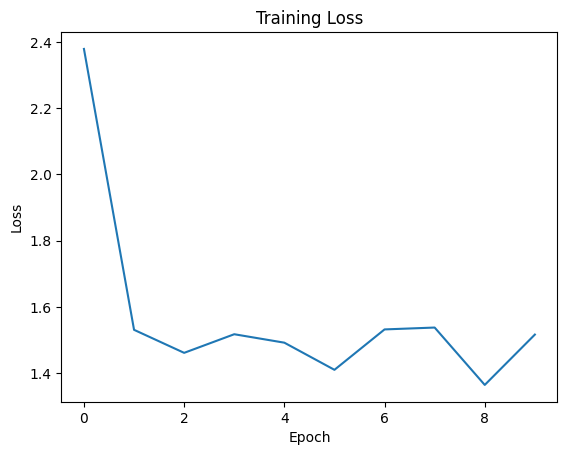

In [20]:
plt.plot([i for i in range(n_epoch)],loss_epoch)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

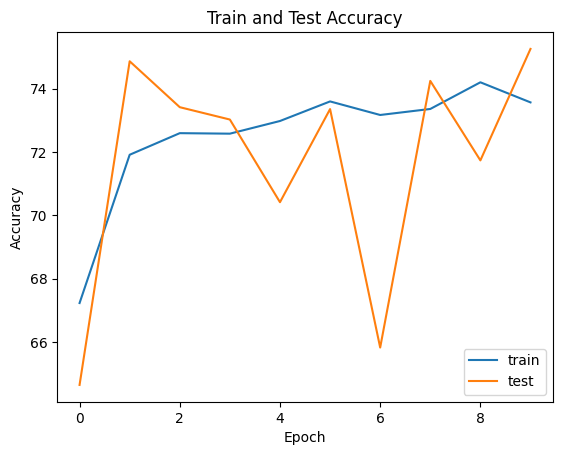

In [21]:
plt.plot([i for i in range(n_epoch)],train_acc_epoch,label='train')
plt.plot([i for i in range(n_epoch)],test_acc_epoch,label='test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Test accuracy by Class

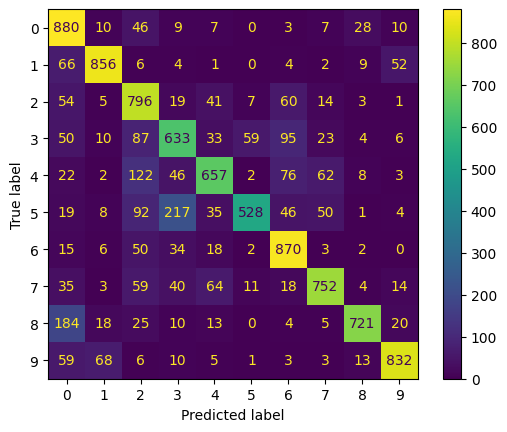

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [41]:
# Testing the model
all_labels=[]
pred=[]
with torch.no_grad(): # Don't update weights when testing
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels = all_labels + labels.tolist()
        pred = pred + predicted.tolist()

cm = confusion_matrix(all_labels, pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

classes

In [52]:
f1 = f1_score(all_labels,pred,average=None)
prec = precision_score(all_labels,pred,average=None)
rec = recall_score(all_labels,pred,average=None)

metrics = pd.DataFrame(np.array([f1,prec,rec]).T,index=classes,columns=['F1','Precision','Recall'])
metrics

,F1,Precision,Recall
airplane,0.738255,0.635838,0.880
automobile,0.862034,0.868154,0.856
bird,0.695500,0.617533,0.796
cat,0.626113,0.619374,0.633
deer,0.701174,0.751716,0.657
dog,0.655901,0.865574,0.528
frog,0.798531,0.737913,0.870
horse,0.782926,0.816504,0.752
ship,0.804239,0.909206,0.721
truck,0.856849,0.883227,0.832


Save output

In [ ]:
save=False
if save:
  import pandas as pd

  torch.save(model.state_dict(),'ResNet_TuneNewFCLayerOnly_CIFAR10_weights.pth')
  values=pd.DataFrame({'loss':loss_epoch,'train_acc':train_acc_epoch,'test_acc':test_acc_epoch})
  values.to_csv('TuneNewFCLayerOnly_accuracy.csv',index=False)
  metrics.to_csv('TuneNewFCLayerOnly_metrics.csv')
  values